# Code for <br> Vincent 2015: A tutorial on Bayesian Models of Perception

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *


In [3]:
import pymc as pm
import arviz as az
import pytensor
import scipy

# setting float precision in pytensor
pytensor.config.floatX = "float32"
import jax
jax.config.update("jax_enable_x64", False)
# check if GPU is available
import torch
if torch.cuda.is_available():
    print(f"Currently using: {torch.cuda.get_device_name(0)} device")
else:
    print("No GPU available, using CPU instead.")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Currently using: NVIDIA GeForce GTX 1080 device


### Load Configs

In [4]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)

ConfigAttributeError: Missing key sorted
    full_key: data.sorted
    object_type=dict

### Utils functions

In [ ]:
import scipy.special


def m1_posterior_prediction(T, si, variance):
    """
    Generate random samples of k based on the given parameters.

    Parameters:
    - T: Number of trials
    - si: Stimulus intensities (scalar or array)
    - variance: Variance parameter (scalar)

    Returns:
    - k: Random samples of k based on the generated binomial distribution
    - PCc: Probability of correct response (scalar or array)
    """

    # Calculate PC using normal CDF
    PCc = scipy.stats.norm.cdf(si / np.sqrt(2 * variance))
    
    # Sample from binomial distribution
    k = np.random.binomial(T, PCc)

    return k, PCc


#### True Model Parameters

In [ ]:
true_variance = 1
true_T = 100
true_si = np.logspace(-2, 2, 10)
true_bias = 0
true_lapse_rate = 0.01
true_prior = np.array([0.5, 0.5])

### Model 1: Statistical Decision Theory with Bayesian estimates

#### 1. Simulate dataset

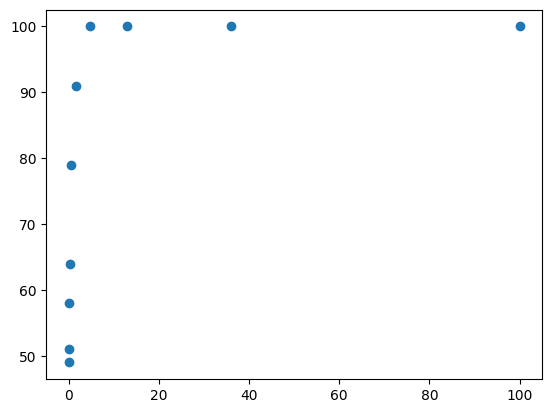

In [ ]:
np.random.seed(42)  # For reproducibility
data = {
    "sioriginal": true_si, # example stimulus intensity
    "T": true_T, # number of trials
    "muN": 0, # mean of the prior
    "v": true_variance, # standard deviation of the prior
}
data["ni"] = 41 # number of iterations
data["sii"] =  np.logspace(-2, 2, data["ni"]) #  interpolated stimulus intensities
data["si"] = np.concatenate([data['sioriginal'], data['sii']]) 
# Generate data['koriginal'] by simulating counts
data["koriginal"], _ = m1_posterior_prediction(data['T'], data['sioriginal'], data['v'])

plt.plot(data['sioriginal'], data['koriginal'], 'o')


#### 2. Parameter Recovery

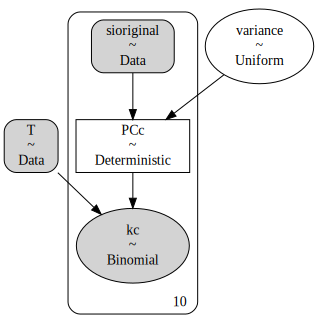

In [28]:
# define the model and calculate the joint probability and posterior
with pm.Model() as model1:
    # Prior
    variance = pm.Uniform("variance", lower=0, upper=1000)
    
    # PCc using Normal CDF
    sioriginal = pm.Data("sioriginal", data["sioriginal"])
    PCc = pm.Deterministic("PCc", pm.math.invlogit(sioriginal / pm.math.sqrt(2 * variance)))
    T = pm.Data("T", data["T"])
    
    # likelihood
    kc = pm.Binomial("kc", n=T, p=PCc, observed=data["koriginal"])
    
model1.to_graphviz()


In [29]:
with model1:
    trace = pm.sample(draws=1000, tune=500, chains=2, cores=4, target_accept=0.95, compute_convergence_checks=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [variance]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Text(0, 0.5, 'Density')

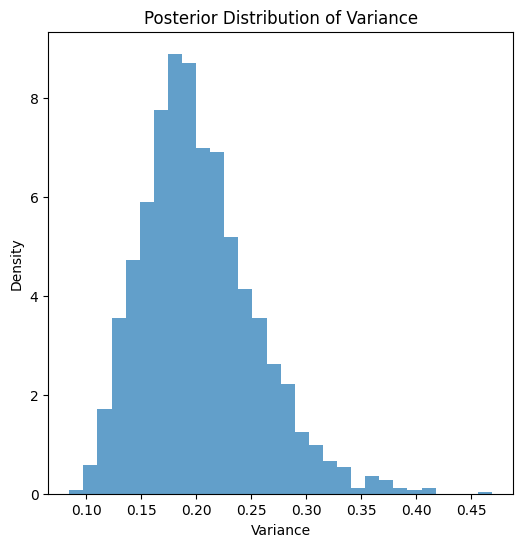

In [30]:
# Extract samples from the trace
variance_samples = trace.posterior["variance"].values.flatten()
# Plotting posterior distributions
plt.figure(figsize=(6, 6))
plt.hist(variance_samples, bins=30, density=True, alpha=0.7)
plt.title('Posterior Distribution of Variance')
plt.xlabel('Variance')
plt.ylabel('Density')


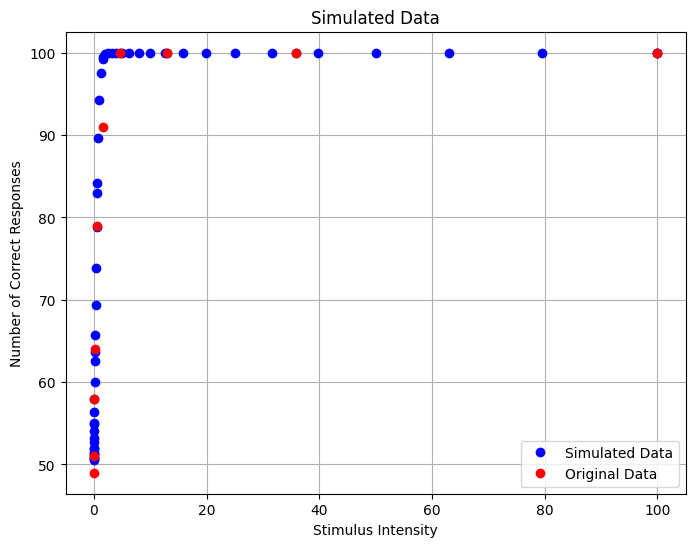

In [101]:

# Extract the variance samples from the trace
variance_samples = trace.posterior["variance"].values.flatten()

# Generate simulated data using posterior samples
def generate_simulated_data(T, si, variance_samples):
    simulated_k = np.zeros((len(variance_samples), len(si)), dtype=int)
    
    for i, variance in enumerate(variance_samples):
        k, _ = m1_posterior_prediction(T, si, variance)
        simulated_k[i] = k
        
    return simulated_k.mean(axis=0)

simulated_k = generate_simulated_data(data['T'], data['si'], variance_samples)

# Plotting simulated data
plt.figure(figsize=(8, 6))
plt.plot(data['si'], simulated_k, marker='o', linestyle='', color='b', label='Simulated Data')
plt.plot(data['sioriginal'], data['koriginal'], marker='o', linestyle="", color='r', label='Original Data')
plt.title('Simulated Data')
plt.xlabel('Stimulus Intensity')
plt.ylabel('Number of Correct Responses')
plt.grid(True)
plt.legend()
plt.show()

## Model 2: A Trial-to-trial SDT model

#### 1. Simulate Data

In [1]:
data["lr"] = true_lapse_rate
data["bias"] = true_bias
data["prior"] = true_prior
data["si"] = np.concatenate([data["sioriginal"], data["sioriginal"], data["sii"]])

NameError: name 'true_lapse_rate' is not defined

In [123]:
data["sioriginal"]

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

#### 2. Model

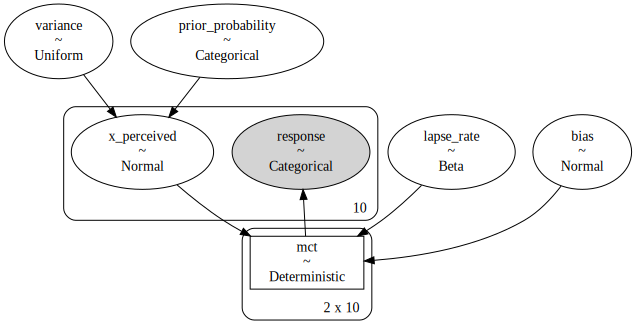

In [124]:
import pytensor.tensor as tt
import pymc as pm

# Assuming 'data' is defined elsewhere in your script
# and it contains 'prior', 'si', and 'koriginal'

with pm.Model() as model2:
    # Prior
    bias = pm.Normal("bias", mu=0, sigma=1/2000)
    lapse_rate = pm.Beta("lapse_rate", alpha=1, beta=1)
    variance = pm.Uniform("variance", lower=0, upper=1000)
    target_location = pm.Categorical("prior_probability", p=data["prior"])
    
    # Likelihoods
    mu_x_perceived = pm.math.switch(tt.eq(target_location, 1), data["sioriginal"], 0)
    x_perceived = pm.Normal("x_perceived", mu=mu_x_perceived, sigma=1/variance)
    
    # Compute mct with compatible shapes
    condition = x_perceived - bias > 0  # condition should be a boolean array
    p_true = tt.stack([1 - lapse_rate/2, lapse_rate/2])  # shape (2,)
    p_false = tt.stack([lapse_rate/2, 1 - lapse_rate/2])  # shape (2,)
    
    # Ensure condition is reshaped correctly for broadcasting
    condition_broadcasted = tt.shape_padleft(condition)
    
    # Ensure p_true and p_false are reshaped to match condition_broadcasted
    p_true_broadcasted = tt.shape_padright(p_true, 1)
    p_false_broadcasted = tt.shape_padright(p_false, 1)
    
    # Use the switch function with the reshaped condition and p_true, p_false
    mct = pm.Deterministic('mct', pm.math.switch(condition_broadcasted, p_true_broadcasted, p_false_broadcasted))
    
    # Response posterior
    response = pm.Categorical("response", p=mct, observed=data["koriginal"])

model2.to_graphviz()
with model2:
    trace = pm.sample(draws=1000, tune=500, chains=2, cores=4, target_accept=0.95, compute_convergence_checks=False)

/usr/local/lib/python3.10/dist-packages/pytensor/tensor/rewriting/shape.py:157: UserWarning: Failed to infer_shape from Op AdvancedSubtensor.
Input shapes: [(TensorConstant(TensorType(int64, shape=()), data=array(10)), TensorConstant(TensorType(int64, shape=()), data=array(2))), (TensorConstant(TensorType(int64, shape=()), data=array(1)), TensorConstant(TensorType(int64, shape=()), data=array(10))), (TensorConstant(TensorType(int64, shape=()), data=array(1)), TensorConstant(TensorType(int64, shape=()), data=array(2)))]
Exception encountered during infer_shape: <class 'ValueError'>
Exception message: Could not broadcast dimensions. Incompatible shapes were [(ScalarConstant(ScalarType(int64), data=1), TensorConstant(TensorType(int64, shape=()), data=array(10))), (ScalarConstant(ScalarType(int64), data=1), TensorConstant(TensorType(int64, shape=()), data=array(2)))].
Traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pytensor/tensor/rewriting/sha

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'bias': array(0., dtype=float32), 'lapse_rate_logodds__': array(0., dtype=float32), 'variance_interval__': array(0., dtype=float32), 'prior_probability': array(0), 'x_perceived': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

Logp initial evaluation results:
{'bias': 6.68, 'lapse_rate': -1.39, 'variance': -1.39, 'prior_probability': -0.69, 'x_perceived': 52.96, 'response': -inf}
You can call `model.debug()` for more details.